Note: Please make a copy of this notebook in your drive before working on it.

# Satellite Image Segmentation

This is a Jupyter notebook provided as a wrapper for training and testing the project about satellite image segmentation using the Unet model architecture. Specifically we perform land segmentation on satellite images.

---

Make sure first your google drive is mounted

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, create a folder/directory (say project_folder) in your drive to create a workspace for the project. Then navigate to the directory using the cell below.

In [ ]:
cd drive/MyDrive/project_folder/

## Cloning the Github repository

In [ ]:
! git clone https://github.com/TarunKumar1995-glitch/land_cover_classification_unet.git

## Downloading the Splitted Dataset
In order to download our dataset you need a Kaggle account. For downloading the data directly to your drive, we use the steps from this blog tutorial [[Download Kaggle Dataset directly to Google Drive]](https://medium.com/analytics-vidhya/how-to-directly-download-kaggle-dataset-to-google-drive-aa06175712e2).

1) Go to Kaggle, log in and click on the `Account` icon with the gear. 

<img src="https://i.ibb.co/d7dmhj0/Screenshot-2021-06-15-20-38-02.png" alt="Screenshot-2021-06-15-20-38-02" width= 300 border="0">

2) Scroll down and find the API section. Click create a new API token

<img src="https://i.ibb.co/swhPMZg/Screenshot-2021-06-15-20-43-05.png" alt="Screenshot-2021-06-15-20-43-05" border="0">

3) Browser will ask you to download json file, named `kaggle.json`. The file contains **Username** and **Key** that will be used for config Google Colab environment.

Fill in your Username and Key from the jason file

In [11]:
#Configuration environment
import os

os.environ['KAGGLE_USERNAME'] = "xxxxx" # username from the json file
os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxxxxxxxxx" # key from the json file

Let us now download the dataset, it will take only a few seconds.

In [ ]:
cd land_cover_classification_unet/

In [ ]:
!kaggle datasets download -d geoap96/deepglobe2018-landcover-segmentation-traindataset

In [ ]:
!unzip deepglobe2018-landcover-segmentation-traindataset.zip -d data/
## will only take a minute

## reorganize the directories
mv  -v data/data/* data/
rm -d data/data/

Alternatively, you can also use a very small subset of the training data already provided in the repository to test the scripts.

---

Move back to the workspace

In [ ]:
cd /content/drive/MyDrive/project_folder/land_cover_classification_unet/

### Package installation

In [ ]:
pip install scikit-build

In [ ]:
pip install segmentation-models-pytorch


## Visualizing the Class imbalance


The following script was written in order to explore how much inbalance there is between our dataset classes. This particularly important prior the training of our Deep Neural Network architecture as it will significantly affect the choice of our loss function.

<u> Warning:</u>  The script for exploring the distribution of each class pixel take 15-20min to run thus we are providing a preview of the results in the following image.

The numbers shown are in milions of pixels. This visualizes the large skewness between our dataset classes.

<p align="center">
<a href="https://imgbb.com/"><img src="https://i.ibb.co/7R1cThD/Screenshot-2021-06-13-14-39-59.png" alt="Screenshot-2021-06-13-14-39-59" border="0" width="400"></a><br />
</p>

In [14]:
%matplotlib inline
%run distribution.py

ERROR:root:File `'distribution.py'` not found.


## **Model Training**
The following cell is used to train the model. The model architecture we are using is called the U-net.  [[U-net]](https://arxiv.org/abs/1505.04597) Is one of the most famous fully convolutional models for semantic segmentation its architecture is presented in the figure below.

<p align="center">
<img src="https://i.ibb.co/2WhDbRv/Screenshot-2021-06-12-20-31-16.png" alt="Screenshot-2021-06-12-20-31-16" border="0"></a>
</p>


<ins>_Guidelines_<ins>

`-f` : Used to load a model already stored in memory.\
`-e` : Used to specify the Number of training epochs.\
`-l` : Used to specify the learning rate to be used for training.\
`-b` : Used to specify the batch size.\
`-v` : Used to specify the percentage of the validation split (1-100).\
`-s` : Used to specify the scale of the image to be used for training.

### The loss function

Different loss function has been explored while implementing this project. However the function that we had concluded to use is a modified version of Cross Entropy which uses weights to fix the imbalance between the classes. The classes with higher presence in the dataset (such as agriculture) are given a smaller weight while classes which have smaller presence are given a higher weight.

- Cross Entropy
<p align="center">
<img src="https://i.ibb.co/370XFj3/Screenshot-2021-06-13-16-40-55.png" alt="Screenshot-2021-06-13-16-40-55" border="0">
</p>

- Weighted Cross Entropy

<p align="center">
<img src="https://i.ibb.co/yhX2QV0/Screenshot-2021-06-13-15-09-03.png" alt="Screenshot-2021-06-13-15-09-03" border="0"></a><br />
</p>

>> <ins> Python Implementation for weight calculation <ins/>
>>>
```python
def classcount(loader):
    n_train = len(loader)
    class_weight = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
    for i in range(n_train):
      for batch in loader:
        imgs, true_masks = batch['image'], batch['mask']
        (unique, counts) = np.unique(true_masks, return_counts=True)
        frequencies = np.asarray((unique, counts))      
        for i in range(frequencies.shape[1]):
            class_weight[frequencies[0,i]] += frequencies[1,i]
    class_weight = class_weight.min()/class_weight
    return class_weight
```

- Dice Loss

<p align="center">

<img src="https://i.ibb.co/Q9kFjvx/Screenshot-2021-06-13-16-23-26.png" alt="Screenshot-2021-06-13-16-23-26" border="0">
</p>

Where:
- p_y_true is the probability of the ith class labels
- p_y_pred is the probability of the ith class prediction
- N_class is the nubmer of classes


>> <ins> Python Implementation <ins/>
>>>
```python
def dice_coeff(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.to(torch.int64)
    y_true_f = torch.nn.functional.one_hot(y_true_f, num_classes=7)    
    y_true_f = torch.flatten()
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred_f = torch.flatten(y_pred.permute(0,2,3,1))
    intersect = torch.sum(y_true_f * y_pred_f, axis=-1)
    denom = torch.sum(y_true_f + y_pred_f, axis=-1)
    return torch.mean((2. * intersect / (denom + smooth)))
def dice_loss(y_true, y_pred):
    return (1 - dice_coeff(y_true, y_pred)) 
```



Note: By default, directory for training is set to a small subset. To train the model on the complete dataset, toggle the codelines in the beginning of the train.py script.

In [ ]:
!python3 train.py -e 100 -v 20.0 -l 1e-5 -b 2 -s 0.2

## **Model Evaluation**
The following cell is used to evaluate the trained model on the test set. The metric of evaluation is the IoU score. Its important to mention that the class "unknown" was ignored as instructed by [[DeepGlobe Challenge]](https://arxiv.org/abs/1805.06561)

<ins>_Guidelines_<ins>

`-m` : Used to specify the directory to the model.\
`-i` : Used to specify the directory of the images to test the model on.\
`-o` : Used to specify the directory in which the predictions will be outputed.\
`-s` : Used to specify the scale of the images to be used for predictions.\
(For best results used the same scale you used for training the model)

_Note:_ Inference of scale 0.2 takes approximately 10 minutes.


In [ ]:
%%time
!python predict.py -m data/checkpoints/model_ep30_full_data.pth -i data/test_data/images/* -o  predictions/ -s 0.2 --viz

### Results Preview

Because inference of the whole test-set takes a lot of time we add a screenshot of the achieved results using our trained model

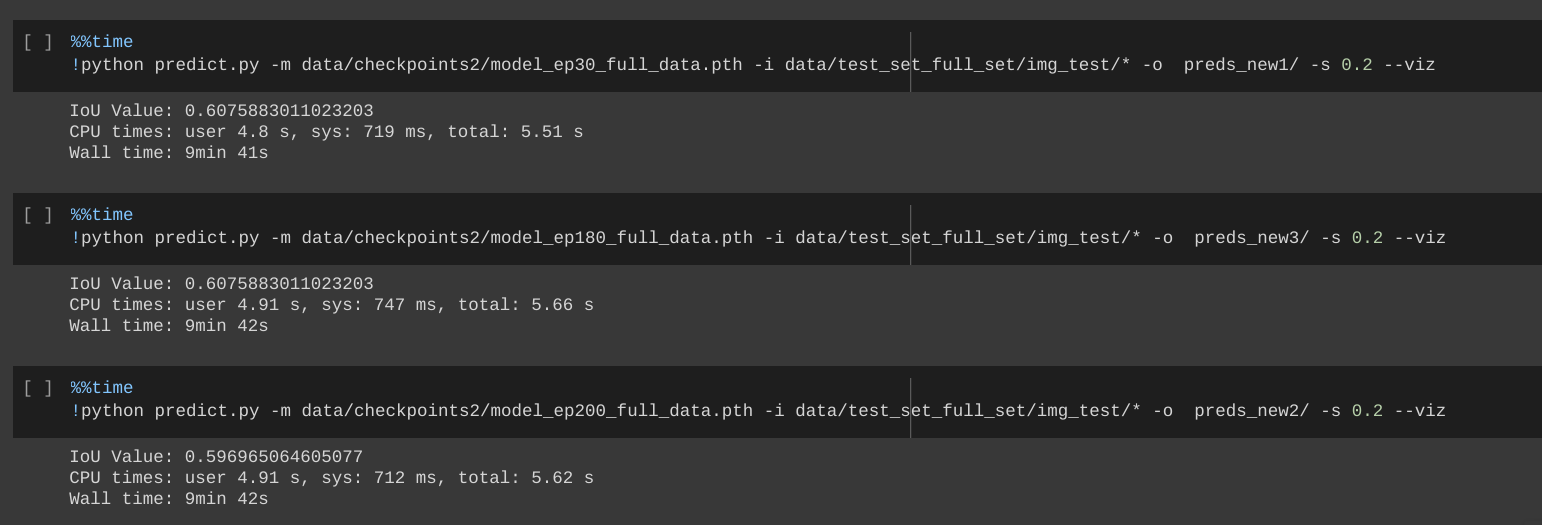


For qualitative analysis, the predicted images in the directory "predictions/" can be compared with the ground truth masks available for the testing data.